# Хакатон Моторика

**Рефакторинг НС модели с TensorFlow на PyTorch.** 

Используются данные второго спринта Моторики. 

In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt 
import OMG_IO_Utils as omg
import torch

RANDOM_SEED = 19
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED);

## Исходные данные

OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

In [2]:
palm_file = './Data/sprint2_pilote2_gestures.palm' 
data = gestures_train = omg.read_omg_csv(palm_file, 
                              n_omg_channels=50,
                              n_acc_channels=3, 
                              n_gyr_channels=3, 
                              n_enc_channels=6, 
                              n_mag_channels=0)

print("Observations shape:", data.shape)
data.head()

Observations shape: (26650, 65)


,0,1,2,3,4,5,6,7,8,9,...,GYR2,ENC0,ENC1,ENC2,ENC3,ENC4,ENC5,BUTTON,SYNC,ts
0,0,0,69,3461,3694,3418,1867,13,7,7,...,-8,13,34,48,35,32,0,0,0,161790
1,0,11,58,3462,3692,3417,1868,13,7,5,...,-1,13,34,48,35,32,0,0,0,161823
2,10,8,51,3463,3693,3418,1870,21,6,6,...,4,13,34,48,35,32,0,0,0,161856
3,11,9,58,3463,3692,3418,1871,13,6,6,...,6,13,34,48,35,32,0,0,0,161889
4,11,8,58,3460,3692,3418,1869,13,6,5,...,7,13,34,48,35,32,0,0,0,161922


In [3]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# [y target]   'ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5' - координаты пальцев в перчатке GLOVE
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
N_OMG = 50 
OMG_CH = [str(i) for i in range(N_OMG)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4'] #ENC5 is empty
GLOVE_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']  #ENC5 is empty
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']
FINGERS = ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(GLOVE_CH)+len(BUTTON_SYNC_TS_CH) == gestures_train.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"GLOVE_CH: {list(GLOVE_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")
print("Fingers:", FINGERS)

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
GLOVE_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']
Fingers: ['Thumb', 'Index', 'Middle', 'Ring', 'Pinky']


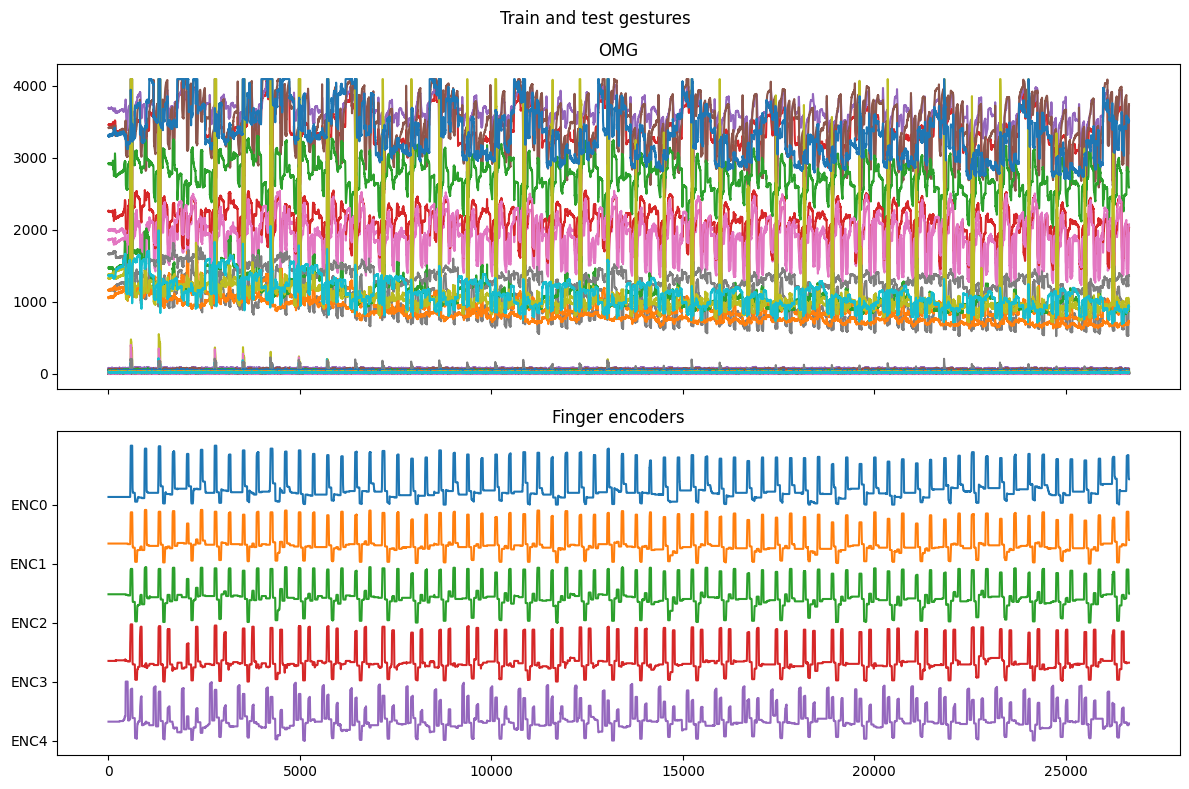

In [4]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(12, 8))
xax = np.arange(gestures_train.shape[0])
plt.sca(axx[0])
plot_train = plt.plot(xax, gestures_train[OMG_CH].values)
#plot_train = plt.plot(gestures_train['ts'].values, gestures_train[OMG_CH].values)
#plt.axvline(train_size, color='k', label='Train-Test split')
plt.title('OMG')
#plt.legend()

plt.sca(axx[1])
plot_train = plt.plot(xax, gestures_train[ENC_CH].values - np.arange(len(ENC_CH)) * 100)
#plot_train = plt.plot(gestures_train['ts'].values, gestures_train[GLOVE_CH].values - np.arange(len(GLOVE_CH)) * 100)
#plt.axvline(train_size, color='k', label='Train-Test split')
plt.yticks(-np.arange(len(ENC_CH)) * 100, ENC_CH)
#plt.legend()
plt.title('Finger encoders')
#plt.xlabel('Timesteps')

plt.suptitle('Train and test gestures')
plt.tight_layout()

High OMG channels: ['3', '4', '5', '6', '12', '13', '16', '17', '21', '22', '27', '28', '30', '31', '38', '39'], Total 16 channels


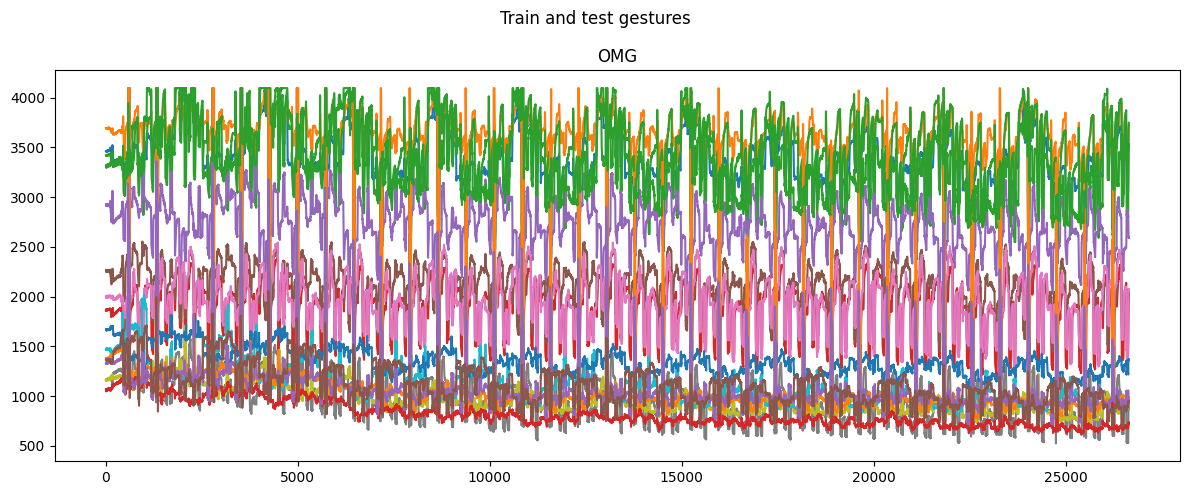

In [5]:
# Выделение каналов по уровню
high_ch = []
for ch in OMG_CH:
    if data[ch].min() > 300: high_ch.append(ch)
#assert len(high_ch) == 16
print(f"High OMG channels: {high_ch}, Total {len(high_ch)} channels")
#high_ch_num = [int(x) for x in high_ch]
#ch_to_delete = [x for x in range(N_OMG) if x not in high_ch_num]
#print(f"Channels to delete {ch_to_delete}")

fig, axx = plt.subplots(1, 1, sharex=True, figsize=(12, 5))
xax = np.arange(data.shape[0])
#plt.sca(axx[0])
plot_train = plt.plot(xax, data[high_ch].values)
#plot_train = plt.plot(gestures_train['ts'].values, gestures_train[OMG_CH].values)
#plt.axvline(train_size, color='k', label='Train-Test split')
#plt.xticks( ticks=[train_size], labels=["Test Cut Off"])
plt.title('OMG')
plt.suptitle('Train and test gestures')
plt.tight_layout()

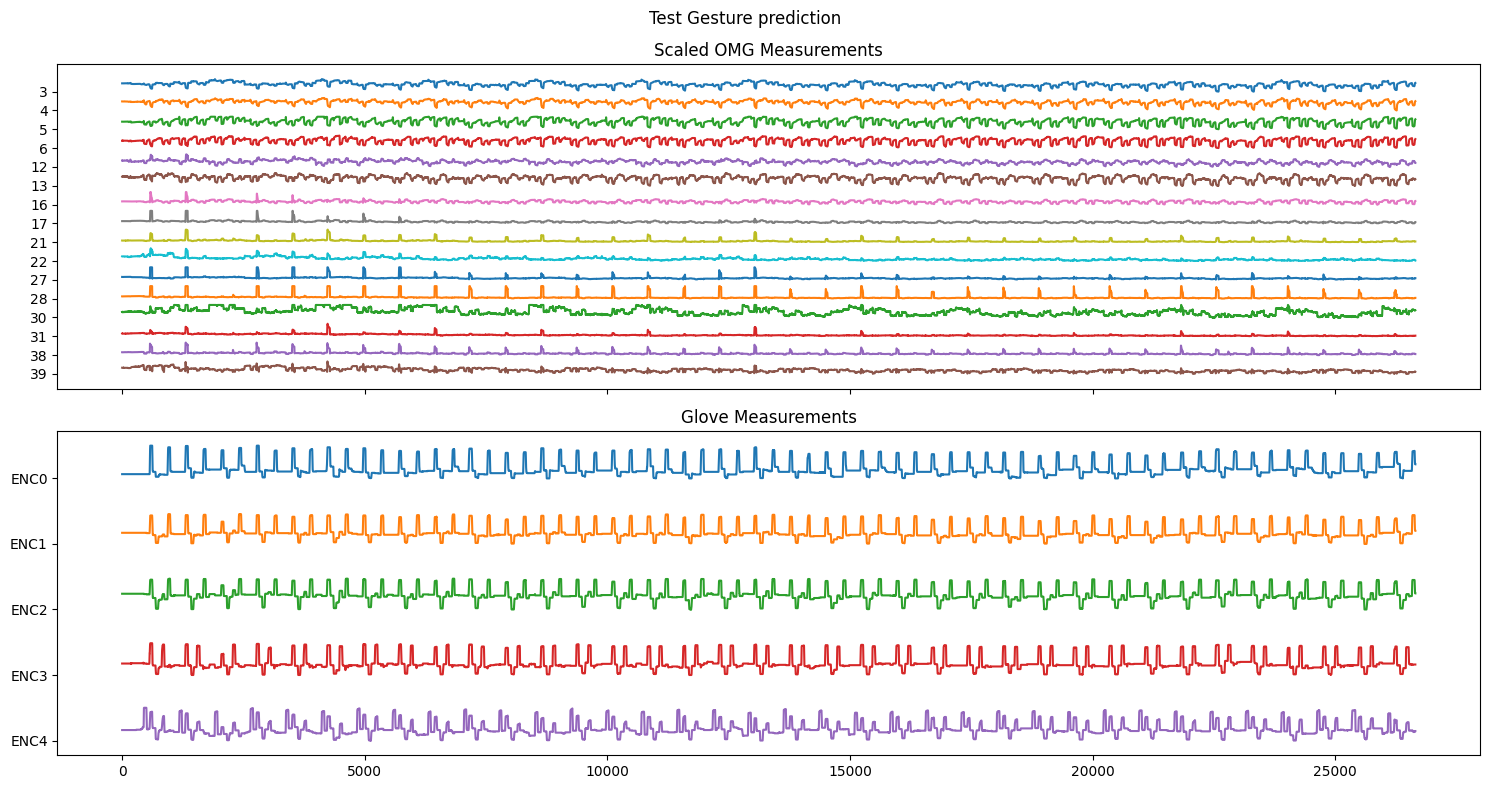

In [6]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

features = scaler.fit_transform(data[high_ch].values)
targets = data[ENC_CH].values
omg_ticks = np.arange(len(high_ch))
enc_ticks = np.arange(len(ENC_CH))

x_axis = np.arange(features.shape[0])
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
plt.sca(axx[0])
plt.plot(x_axis, features - omg_ticks * 1.5)
plt.yticks(-omg_ticks * 1.5, high_ch)
#plt.legend()
plt.title('Scaled OMG Measurements')

plt.sca(axx[1])
plt.plot(x_axis, targets - enc_ticks * 200)
plt.yticks(-enc_ticks * 200, ENC_CH)
#plt.legend()
plt.title('Glove Measurements')
#plt.sca(axx[1])
#plt.plot(x_axis, y_pred - np.arange(len(CH)) * 200)
#plt.yticks(-np.arange(len(CH)) * 200, CH)
#plt.legend()
#plt.title('Predictions')
plt.suptitle('Test Gesture prediction')
plt.tight_layout()

In [7]:
# Нарезка данных на куски для обучения, валидации обучения и тестирования

TRAIN_SHARE = 0.7
TEST_SHARE = 0.15

total_len = len(features)
train_size = round(total_len*TRAIN_SHARE)
test_size = round(total_len*TEST_SHARE)
valid_lim = total_len-test_size

X_train = features[:train_size,:]
Y_train = targets[:train_size,:]
train_sz = X_train.shape[0]

X_valid = features[train_size:valid_lim,:]
Y_valid = targets[train_size:valid_lim,:]
valid_sz = X_valid.shape[0]

X_test = features[valid_lim:,:]
Y_test = targets[valid_lim:,:]
test_sz = X_test.shape[0]

print(f" Train {train_sz}, validation {valid_sz}, test {test_sz}, total {train_sz+valid_sz+test_sz} time steps")

 Train 18655, validation 3997, test 3998, total 26650 time steps


Формирование датасета для временных данных.  Его особенность: при каждом обращении вовзрашается два тензора - X и Y.
- У имеет единичный размер по первому измерению. Фактически это срез значений в момент времени. 
- X имеет размер sequence_length по первому измерению. Фактически это - скользящее окно, выводящее информацию о текущем и предыдущих значениях во времени.  Для начальных точек отсутствующие налюдения приравниваются к нулевому и происходит заполнение тензора. 

Идея взята из публикации "[How to use PyTorch LSTMs for time series regression](https://www.crosstab.io/articles/time-series-pytorch-lstm/)".

In [8]:
from torch.utils.data import Dataset

class SequenceDataset(Dataset):
    def __init__(self, features, target, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(target).float()
        self.X = torch.tensor(features).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i,:]

In [9]:
# Проверка работы датасета
train_dataset = SequenceDataset( X_test, Y_test, 4)
X, Y = train_dataset[1]
print(X)

tensor([[0.5368, 0.5671, 0.5111, 0.5699, 0.3484, 0.5703, 0.2496, 0.1034, 0.0134,
         0.0930, 0.0801, 0.0196, 0.0805, 0.0284, 0.0663, 0.2733],
        [0.5368, 0.5671, 0.5111, 0.5699, 0.3484, 0.5703, 0.2496, 0.1034, 0.0134,
         0.0930, 0.0801, 0.0196, 0.0805, 0.0284, 0.0663, 0.2733],
        [0.5368, 0.5671, 0.5111, 0.5699, 0.3484, 0.5703, 0.2496, 0.1034, 0.0134,
         0.0930, 0.0801, 0.0196, 0.0805, 0.0284, 0.0663, 0.2733],
        [0.5435, 0.5535, 0.4965, 0.5540, 0.3819, 0.6045, 0.2553, 0.1104, 0.0125,
         0.0980, 0.0823, 0.0154, 0.2315, 0.0293, 0.0670, 0.2725]])


In [10]:
from torch.utils.data import DataLoader

SEQUENCE_LEN = 33
BATCH_SIZE = 8

train_dataset = SequenceDataset(X_train, Y_train, SEQUENCE_LEN)
valid_dataset = SequenceDataset(X_valid, Y_valid, SEQUENCE_LEN)
test_dataset = SequenceDataset(X_test, Y_test, SEQUENCE_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

X, Y = next(iter(train_loader))
print(f"X: {X.shape}, Y: {Y.shape}")


X: torch.Size([8, 33, 16]), Y: torch.Size([8, 5])


# НС Модель

При переносе модели выявилось несколько тонкостей: 
- Torch требует обязательного указания размера шкалы времени. Похоже, что нельзя просто обучить на наблюдениях из 100 временных шагов и потом сделать инференс на 1000 шагов. 
- LSTM ячейка формирует на выходе не только основной результат, но и память внутренних состояний (h,c). Это можно сохранять для дальнейшего использования - например моделирования statefull RNN.
- LSTM ячейка на выходе дает тензор размера (num_batch, num_ts, num_rnn). В моем случае это было (8,50,32). Для корректной последующей работы мне нужна была иная размерность выходного тензора RNN - (num batch, num_rnn) с последнего такта работы ячейки.  Этого можно достичь двумя способами в коде forward: 
    - способ 1: 
    ```
        _, (hn, _) = self.lstm(x, (h0, c0)) 
        out = self.linear(hn[0])
        # Здесь (h0,c0) - память начального состояния
    ```
    - способ 2:
    ```
        rnn, _ = self.lstm(x) 
        out = self.linear(rnn[:,-1,:])
    ```

In [11]:
from torch import nn

N_IN = X_train.shape[1]
N_OUT = Y_train.shape[1]
N_RNN = 32
N_HIDDEN = 30

class MotoricaModel(nn.Module):
    def __init__(self, num_in, rnn_units, num_hidden, num_out):
        super().__init__()
        #self.num_in = num_sensors  # this is the number of features
        #self.rnn_units = rnn_units
        #self.num_layers = 1

        self.lstm = nn.LSTM( input_size=num_in, hidden_size=rnn_units, batch_first=True, num_layers=1 )
        self.stack = nn.Sequential(
            nn.Linear(in_features= rnn_units, out_features= num_hidden),
            nn.ReLU(),
            nn.BatchNorm1d(num_hidden),
            nn.Dropout(0.2),
            nn.Linear(in_features=num_hidden, out_features=num_out) )

    def forward(self, x):
        #batch_size = x.shape[0]
        #h0 = torch.zeros(self.num_layers, batch_size, self.rnn_units).requires_grad_()
        #c0 = torch.zeros(self.num_layers, batch_size, self.rnn_units).requires_grad_()
        
        #_, (hn, _) = self.lstm(x, (h0, c0))
        #self.rnn = hn[0]
        #out = self.linear(hn[0]) #.flatten()  # First dim of Hn is num_layers, which is set to 1 above.
        rnn, _ = self.lstm(x) #,  Если (h0, c0) нет - они формируются как нулевые. 
        return self.stack(rnn[:,-1,:]) 

model = MotoricaModel(N_IN, N_RNN, N_HIDDEN, N_OUT)
print(model)
print("Output shape:", model(X).shape)

MotoricaModel(
  (lstm): LSTM(16, 32, batch_first=True)
  (stack): Sequential(
    (0): Linear(in_features=32, out_features=30, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=30, out_features=5, bias=True)
  )
)
Output shape: torch.Size([8, 5])


## Обучение модели


In [12]:
def train_model(model,loader, loss_fn, optimizer):
    cum_loss = 0
    num_batches = len(loader)
    model.train()
    for X_batch, y_batch in loader:
        #print(X_batch.shape)
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        cum_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return cum_loss/num_batches

def evaluate_loss(model, loader, loss_fn):
    cum_loss = 0
    num_batches = len(loader)
    model.eval()
    with torch.no_grad(): 
        for X, y in loader:
            pred = model(X)
            cum_loss += loss_fn(pred, y).item()
    return cum_loss/num_batches


Специальный класс для сохранения pytorch модели. 

In [13]:
# Класс для инкапсуляции механики сохранения лучшей модели.
# Использует вызов `globals()["ClassName"]` или просто 'ClassName' для сохранения дефиниции объекта без его инициализации.
# Для инициализации надо отдельно передать кортеж параметров иницализации.

class ModelSaver():
    def __init__(self, model, arguments, filename):
        self.model = model
        self.arguments = arguments
        self.filename = filename
        self.metric = 1e+06

    def create_model(self):    
        return self.model(*self.arguments)
    
    def save(self, instance, quality):
        if self.metric > quality: 
            self.metric = quality
            torch.save(instance.state_dict(), self.filename)
    
    def load_best(self):
        new_instance = self.model(*self.arguments)
        new_instance.load_state_dict(torch.load(self.filename))
        return new_instance

In [14]:
LEARNING_RATE = 5e-4

saver = ModelSaver( MotoricaModel,                  # определение модели  globals()["MotoricaModel"]
                   (N_IN, N_RNN, N_HIDDEN,N_OUT),   # параметры инициализации
                   './Models/230922_01.pth')        # имя файла для сохранения модели
model = saver.create_model()

optimizer = torch.optim.Adam(model.parameters(),lr=LEARNING_RATE)
loss_fn = nn.MSELoss()
train_loss, valid_loss = [], []
best_valid_loss = 10000


In [15]:
from tqdm import tqdm

N_EPOCH = 100

for epoch in tqdm(range(N_EPOCH)):
    train_loss.append(train_model(model,train_loader, loss_fn, optimizer))
    valid_loss.append(evaluate_loss(model, valid_loader, loss_fn))
    saver.save(model, valid_loss[-1])

inf_model = saver.load_best() 
inf_model.eval()


  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [12:35<00:00,  7.55s/it]


MotoricaModel(
  (lstm): LSTM(16, 32, batch_first=True)
  (stack): Sequential(
    (0): Linear(in_features=32, out_features=30, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=30, out_features=5, bias=True)
  )
)

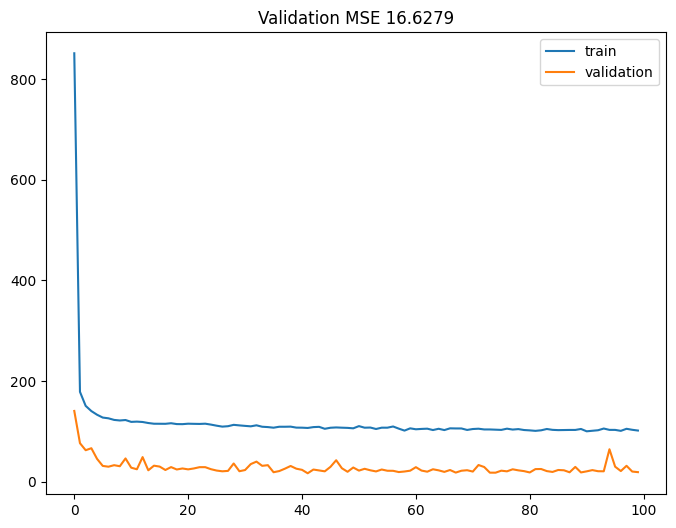

In [16]:
fig = plt.figure(figsize=(8,6))
plt.plot(train_loss, label='train')
plt.plot(valid_loss, label='validation')
plt.legend(loc='best')
plt.title(f"Validation MSE {saver.metric:.4f}")
plt.show();

## Анализ качества модели

In [17]:
prediction = []
inf_model.eval()
with torch.no_grad():
    prediction = [inf_model(X).numpy() for X, _ in test_loader]

prediction = np.concatenate(prediction, axis=0)
prediction.shape

(3998, 5)

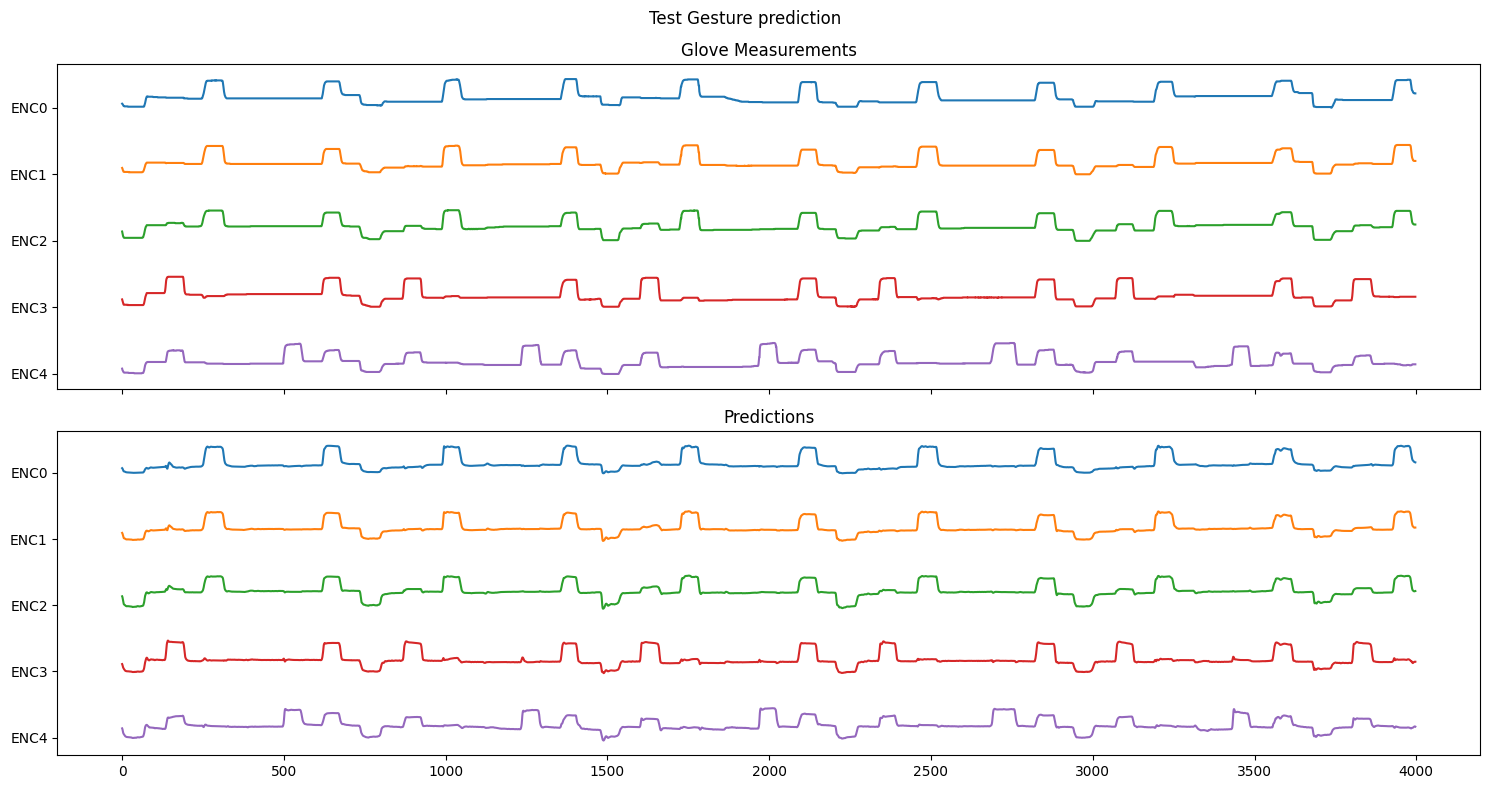

In [18]:
x_axis = np.arange(Y_test.shape[0])
enc_ticks = -np.arange(len(ENC_CH))*200

fig, axx = plt.subplots(2, 1, sharex=True, figsize=(15, 8))
plt.sca(axx[0])
plt.plot(x_axis, Y_test + enc_ticks)
plt.yticks(enc_ticks, ENC_CH)
#plt.legend()
plt.title('Glove Measurements')
plt.sca(axx[1])
plt.plot(x_axis, prediction + enc_ticks)
plt.yticks(enc_ticks, ENC_CH)
#plt.legend()
plt.title('Predictions')
plt.suptitle('Test Gesture prediction')
plt.tight_layout()
#plt.xlim(0,1000)
plt.show();

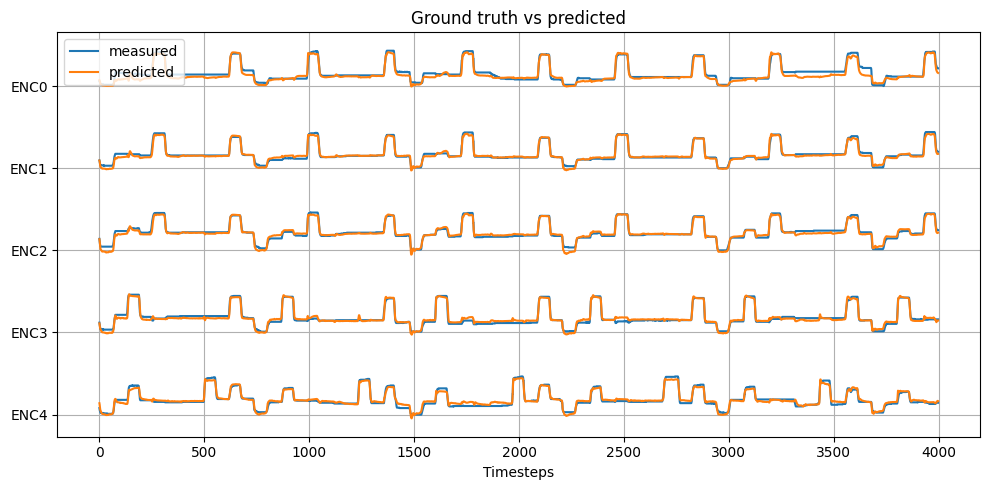

In [19]:

fig = plt.figure(figsize=(10, 5))
lines = []
labels = []

plots = plt.plot(Y_test + enc_ticks, c='C0')
lines += [plots[0]]
labels += ['measured']

plots = plt.plot( prediction + enc_ticks, c='C1')
lines += [plots[0]]
labels += ['predicted']

plt.title('Ground truth vs predicted')
plt.yticks(enc_ticks, ENC_CH)
plt.legend(lines, labels)
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout();